<a href="https://colab.research.google.com/github/huberyhub/himal_hubery_mateo_DP_Project/blob/main/advnaced_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Necessary Libraries

In [33]:
!pip install transformers
!pip install torch
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Define Dataset Class

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len, prices=None):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.prices = prices

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        headline = str(self.headlines[idx])
        label = self.labels[idx]
        price_info = self.prices[idx] if self.prices is not None else ""

        encoding = self.tokenizer.encode_plus(
            headline + " " + price_info,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'price_info': price_info
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    # Create a new column that concatenates the price information into a single string
    df['Price_Info'] = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].astype(str).agg(' '.join, axis=1)

    ds = NewsDataset(
        headlines=df['Combined_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        prices=df['Price_Info'].to_numpy()
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=0)




Data Set Processing

In [56]:
import pandas as pd

# Load the datasets
djia_df = pd.read_csv('/content/upload_DJIA_table.csv')
headlines_df = pd.read_csv('/content/Combined_News_DJIA.csv')

# Display the first few rows to understand the structure
print("Headlines Dataset:")
print(headlines_df.head())
print("\nDJIA Dataset:")
print(djia_df.head())

# Reverse the headlines dataset to match the date order with DJIA dataset
headlines_df = headlines_df.iloc[::-1].reset_index(drop=True)

# Display the first few rows to verify
print(headlines_df.head())

# Combine all headline columns into a single text field
headline_columns = [col for col in headlines_df.columns if col.startswith('Top')]
headlines_df['Combined_Headlines'] = headlines_df[headline_columns].apply(lambda row: ' '.join(row.dropna().values.astype(str)), axis=1)

# Keep only the necessary columns
headlines_df = headlines_df[['Date', 'Combined_Headlines', 'Label']]  # Ensure 'Label' column is included

# Display the first few rows to verify
print("Combined Headlines Dataset:")
print(headlines_df.head())


# Drop any potential duplicates in the DJIA dataset
#if 'Combined_Headlines' in djia_df.columns:
    #djia_df = djia_df.drop(columns=['Combined_Headlines'])

# Merge the datasets on the Date column
merged_df = pd.merge(djia_df, headlines_df, on='Date', how='inner')

# Display the first few rows to verify the merge
print("Merged Dataset:")
print(merged_df.head())

# Save the merged dataframe to a new CSV file
merged_df.to_csv('/Merged_DJIA_Headlines.csv', index=False)


Headlines Dataset:
         Date  Label                                               Top1  \
0  2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1  2008-08-11      1  b'Why wont America and Nato help us? If they w...   
2  2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   
3  2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...   
4  2008-08-14      1  b'All the experts admit that we should legalis...   

                                                Top2  \
0            b'BREAKING: Musharraf to be impeached.'   
1        b'Bush puts foot down on Georgian conflict'   
2                 b"Russia 'ends Georgia operation'"   
3  b"When the president ordered to attack Tskhinv...   
4  b'War in South Osetia - 89 pictures made by a ...   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   
2  b'"If we had no sexual

Load Data and Prepare Data Loaders

In [36]:
# Assuming your dataset is loaded into a DataFrame called df
df = pd.read_csv('Merged_DJIA_Headlines.csv')

# Optimized by directly using pandas functionality
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create data loaders
MAX_LEN = 128
BATCH_SIZE = 16

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)


Model Setup

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

# 10 epochs
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Loop

In [58]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

EPOCHS = 10

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Example of model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 16

# Assuming merged_df is the merged dataset created previously
train_data_loader = create_data_loader(merged_df, tokenizer, MAX_LEN, BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(merged_df)  # Assuming merged_df is the training dataset
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,  # Assuming val_data_loader is defined similarly
        loss_fn,
        device,
        len(merged_df)  # Assuming merged_df is the validation dataset
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6988975005149841 accuracy 0.5188536953242835
Val loss 0.7044781125508822 accuracy 0.043237807943690296
Epoch 2/10
----------
Train loss 0.6900762529373169 accuracy 0.5268979386626444
Val loss 0.7507824851916387 accuracy 0.043237807943690296
Epoch 3/10
----------
Train loss 0.6555416843891144 accuracy 0.6153846153846153
Val loss 0.8523603998697721 accuracy 0.043237807943690296
Epoch 4/10
----------
Train loss 0.4903385052680969 accuracy 0.7702362996480643
Val loss 1.2511384120354285 accuracy 0.043237807943690296
Epoch 5/10
----------
Train loss 0.32047417747974394 accuracy 0.8677727501256912
Val loss 1.4392345043329091 accuracy 0.043237807943690296
Epoch 6/10
----------
Train loss 0.20577189926803113 accuracy 0.9260935143288084
Val loss 2.037805071243873 accuracy 0.043237807943690296
Epoch 7/10
----------
Train loss 0.16937269985675812 accuracy 0.9371543489190547
Val loss 2.1354646499340353 accuracy 0.043237807943690296
Epoch 8/10
----------
Train loss

Evaluation and Visualization

['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan

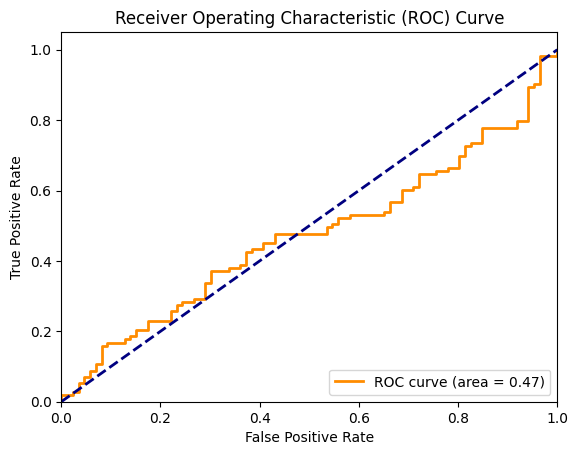

In [68]:
def get_predictions(model, data_loader):
    model = model.eval()

    headlines_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["headline_text"]
            print(texts)
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)

            headlines_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return headlines_texts, predictions, prediction_probs, real_values

y_headlines, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    val_data_loader
)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [60]:
# Save the trained model
model_save_path = 'bert_sequence_classification_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Load the saved model
model_load_path = 'bert_sequence_classification_model.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load(model_load_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode
print(f'Model loaded from {model_load_path}')

Model saved to bert_sequence_classification_model.pth


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from bert_sequence_classification_model.pth


Qualitative Analysis of Miscalculations

In [ ]:
def analyze_misclassifications(model, data_loader, device):
    model = model.eval()

    misclassified_examples = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["headline_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            for text, pred, label in zip(texts, preds, labels):
                if pred != label:
                    misclassified_examples.append((text, pred.item(), label.item()))

    return misclassified_examples

# Analyze misclassifications
misclassifications = analyze_misclassifications(model, val_data_loader, device)

# Display misclassified examples
for text, pred, label in misclassifications[:10]:  # Display first 10 misclassifications
    print(f"Headline: {text}")
    print(f"Predicted: {pred}, Actual: {label}")
    print("----")


## full implementation

In [70]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import random

# Load the datasets
djia_df = pd.read_csv('/content/upload_DJIA_table.csv')
headlines_df = pd.read_csv('/content/Combined_News_DJIA.csv')

# Reverse the headlines dataset to match the date order with DJIA dataset
headlines_df = headlines_df.iloc[::-1].reset_index(drop=True)

# Combine all headline columns into a single text field
headline_columns = [col for col in headlines_df.columns if col.startswith('Top')]
headlines_df['Combined_Headlines'] = headlines_df[headline_columns].apply(lambda row: ' '.join(row.dropna().values.astype(str)), axis=1)

# Keep only the necessary columns
headlines_df = headlines_df[['Date', 'Combined_Headlines']]

# Merge the datasets on the Date column
merged_df = pd.merge(djia_df, headlines_df, on='Date', how='inner')

# Label the data for longer-term predictions
def label_trend(data, short_term_window=1, long_term_window=5):
    data['Label'] = 0  # Initialize all labels to 0
    for i in range(len(data) - long_term_window):
        short_term_change = data['Close'].iloc[i + short_term_window] - data['Open'].iloc[i]
        long_term_change = data['Close'].iloc[i + long_term_window] - data['Open'].iloc[i]
        if short_term_change > 0 and long_term_change > 0:
            data['Label'].iloc[i] = 1  # Upward trend
        elif short_term_change < 0 and long_term_change < 0:
            data['Label'].iloc[i] = 0  # Downward trend
        else:
            data['Label'].iloc[i] = 2  # No clear trend
    return data

merged_df = label_trend(merged_df)

# Save the merged dataframe to a new CSV file
merged_df.to_csv('/content/Merged_DJIA_Headlines.csv', index=False)

# Define the NewsDataset class
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len, prices=None):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.prices = prices

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        headline = str(self.headlines[idx])
        label = self.labels[idx]
        price_info = self.prices[idx] if self.prices is not None else ""

        if pd.isna(headline):
            headline = ""

        encoding = self.tokenizer.encode_plus(
            headline + " " + price_info,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define the create_data_loader function
def create_data_loader(df, tokenizer, max_len, batch_size):
    df['Price_Info'] = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].astype(str).agg(' '.join, axis=1)

    ds = NewsDataset(
        headlines=df['Combined_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        prices=df['Price_Info'].to_numpy()
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=0)

# Example of model training
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model = model.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 16

train_data_loader = create_data_loader(merged_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(merged_df, tokenizer, MAX_LEN, BATCH_SIZE) # Make sure to split data for training and validation

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def analyze_misclassifications(model, data_loader, device):
    model = model.eval()

    misclassified_examples = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["headline_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            for text, pred, label in zip(texts, preds, labels):
                if pred != label:
                    misclassified_examples.append((text, pred.item(), label.item()))

    return misclassified_examples

# Train and evaluate the model
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(merged_df)  # Assuming merged_df is the training dataset
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,  # Assuming val_data_loader is defined similarly
        loss_fn,
        device,
        len(merged_df)  # Assuming merged_df is the validation dataset
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

# Save the trained model
model_save_path = 'bert_sequence_classification_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Load the saved model
model_load_path = 'bert_sequence_classification_model.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(model_load_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode
print(f'Model loaded from {model_load_path}')



Streaming output truncated to the last 5000 lines.
  data['Label'].iloc[i] = 2  # No clear trend
<ipython-input-70-33cee9f6e71e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'].iloc[i] = 2  # No clear trend
<ipython-input-70-33cee9f6e71e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'].iloc[i] = 2  # No clear trend
<ipython-input-70-33cee9f6e71e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['La

Epoch 1/10
----------
Train loss 1.0059141111373902 accuracy 0.5610859728506786
Val loss 0.9822880110740662 accuracy 0.5701357466063348
Epoch 2/10
----------
Train loss 0.9993836612701416 accuracy 0.5681246857717446
Val loss 0.9802133207321166 accuracy 0.5701357466063348
Epoch 3/10
----------
Train loss 0.9974229865074158 accuracy 0.5701357466063348
Val loss 0.9776329703330994 accuracy 0.5701357466063348
Epoch 4/10
----------
Train loss 0.9897134990692139 accuracy 0.5701357466063348
Val loss 0.9676000361442566 accuracy 0.5701357466063348
Epoch 5/10
----------
Train loss 0.9806938920021057 accuracy 0.5706385118149824
Val loss 0.926765909910202 accuracy 0.5887380593262945
Epoch 6/10
----------
Train loss 0.9567924227714538 accuracy 0.5827048768225238
Val loss 0.8850631878376007 accuracy 0.6093514328808446
Epoch 7/10
----------
Train loss 0.8766495695114136 accuracy 0.6314731020613373
Val loss 0.7644876101016999 accuracy 0.6767219708396178
Epoch 8/10
----------
Train loss 0.76111828422546

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from bert_sequence_classification_model.pth
Headline: Gay Chinese man sues mental hospital for trying to cure him with drugs and beatings Goldman Sachs hired prostitutes to win Libyan business 'Man holed up in Paris suburban home with hostages after killing policeman' A group of Pakistani clerics has issued a fatwa, or religious ruling, declaring "honour killing" over perceived damage to a family's reputation against the teaching of Islam, and anyone who carries out such an attack a heretic Animal Welfare Institute Report: Norway is now the worlds leading whaling nation, killing more whales in the past two years than Japan and Iceland combined. ISIS leader al-Baghdadi killed in air strike: Report Leaked secret audio recordings of Brazils most powerful figures have sparked a series of explosive scandals in the nations ongoing political crisis. Now, Brazilian lawmakers are trying to outlaw publication of such recordings US with 5 percent of the world's population has nearly 

Accuracy: 0.8663
Classification Report:
                precision    recall  f1-score   support

      Downward       0.89      0.71      0.79       426
        Upward       0.83      0.69      0.76       429
No Clear Trend       0.87      0.99      0.93      1134

      accuracy                           0.87      1989
     macro avg       0.86      0.80      0.82      1989
  weighted avg       0.87      0.87      0.86      1989



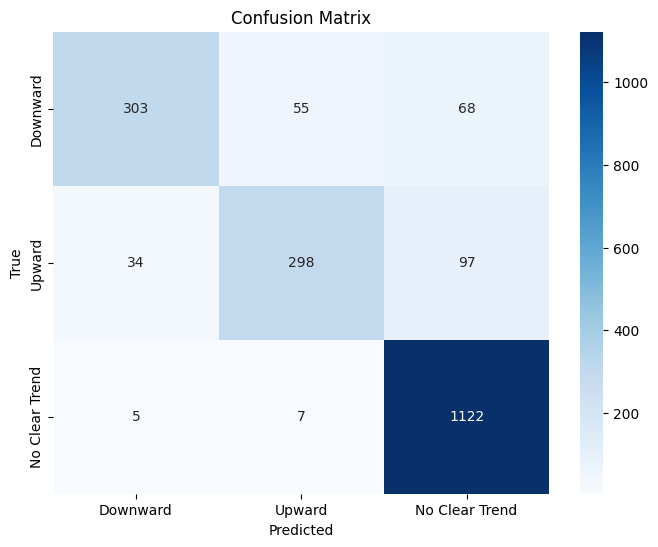

In [73]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get predictions and true labels
def get_predictions(model, data_loader, device):
    model = model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, val_data_loader, device)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

# Generate classification report
class_report = classification_report(true_labels, predictions, target_names=['Downward', 'Upward', 'No Clear Trend'])
print('Classification Report:')
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Downward', 'Upward', 'No Clear Trend'], yticklabels=['Downward', 'Upward', 'No Clear Trend'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [74]:
# Test random headlines
def test_random_headlines(df, tokenizer, model, device, num_samples=10):
    samples = df.sample(n=num_samples)
    for index, row in samples.iterrows():
        headline = row['Combined_Headlines']
        price_info = row['Price_Info'] if 'Price_Info' in row else ""

        encoding = tokenizer.encode_plus(
            headline + " " + price_info,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

        print(f"Headline: {headline}")
        print(f"Predicted: {preds.item()}")
        print("----")

# Test random headlines
test_random_headlines(merged_df, tokenizer, model, device)

Headline: Saudi Arabia put into effect a sweeping new counterterrorism law Sunday that human rights activists say allows the kingdom to prosecute as a terrorist anyone who demands reform, exposes corruption or otherwise engages in dissent. Hackers Sue German Government Over NSA Spying David Miranda's detention: a chilling attack on journalism | When the partner of journalist Glenn Greenwald was detained at Heathrow airport last August under the Terrorism Act, MI5 were pulling the strings and knew full well that he wasn't a terrorist WikiLeaks founder Julian Assange has claimed that a woman he is alleged to have raped sent text messages admitting that he never assaulted her | In an affidavit published on the WikiLeaks website, Assange cites several SMS messages supposedly exchanged between his two alleged victims. Corruption in the EU is "breathtaking" says EU Commissioner. Australian PM has Video removed and YouTube Account closed for violations Financial world shaken by 4 bankers' app